# Estimating the relationship between hematite grain size and unblocking temperature


Text from Swanson-Hysell et al. (2011):

> Although hematite is known to have a N\'eel temperature of $\sim$675$^{\circ}$ C, its unblocking temperature is also a function of grain volume (v), saturation magnetization (M$_{s}$), and microscopic coercivity (H$_{c}$; Pullaiah et al., 1975). According to Neel (1949a), the relaxation time ($\tau$) magnetization held by an assemblage of non-interacting single-domain grains can be calculated as:

\begin{equation}
\tau=C^{-1}e^{\frac{v\mu_{o}M_{s}H_{c}}{2kT}}
\end{equation} 

> where C is the characteristic frequency of thermal fluctuation (in Hz), $\mu_{o}$ is the permeability of free space, k is Boltzmann's constant, and T is temperature.  Both M$_{s}$ and H$_{c}$ are themselves a function of temperature, and we use the empirical temperature-dependent behavior of M$_{s}$ reported by Ozdemir and Dunlop (2005) in this analysis.  The microscopic coercivity of hematite is dominated by magnetoelastic effects and the temperature dependence of these effects remains poorly defined.  Following the example of Pullaiah et al. (1975), we calculate the temperature dependence of H$_{c}$ as proportional to M$_{s}$(T)$^{3}$ normalizing to the room-temperature coercivity of a population of naturally-occurring 500-3000 nm diameter hematite grains (260 mT; Dunlop, 2001).

This code is translated into Python from a Mathematica notebook initially developed by Josh Feinberg.

In [1]:
import numpy as np
import pandas as pd
import scipy.constants
from scipy import interpolate
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats=['svg']

## Constants that are needed in the code.

The permeability of free space ($\mu_0$) and Boltzmann's constant can be accessed via the scipy.constants module. The saturation magnetization of hematite ($M_s$) at room temperature is taken from Dunlop and Özdemir (1997) and is 2.5 kAm$^{-1}$.

In [2]:
boltzman = scipy.constants.Boltzmann
mu = scipy.constants.mu_0
Ms = 2500

## Ms(T) curve

This portion of the code calculates an Ms (T) curve for hematite in a rather brute force method (500 degree polynomial) using the data from Ozdemir and Dunlop (2005). The output units of the function MsofT(x) are A/m. The input file has magnetization in normalized arbitary units which are then converted into A/m by multiplying by Ms at room temperature (2500 A/m). The units of the input file for temperature are in celcius they are converted into Kelvin below.

In [3]:
MsT_data = pd.read_csv('./data/Ozdemir2005a.txt',delimiter=',')
MsT_data['temp_kelvin'] = MsT_data['temp_celcius'] + 273
MsT_data = MsT_data.drop(590)
MsT_data.reset_index(inplace=True)
MsT_data['MsT_normalized'] = (MsT_data.Ms_T - MsT_data.Ms_T[len(MsT_data)-1])/(MsT_data.Ms_T[0] - MsT_data.Ms_T[len(MsT_data)-1])
MsT_data['MsT_Am'] = MsT_data.MsT_normalized * Ms
MsT_data.tail()

,index,temp_celcius,Ms_T,temp_kelvin,MsT_normalized,MsT_Am
1238,1239,717.2531,0.0745,990.2531,0.0,0.0
1239,1240,717.8486,0.0745,990.8486,0.0,0.0
1240,1241,718.4441,0.0745,991.4441,0.0,0.0
1241,1242,719.0396,0.0745,992.0396,0.0,0.0
1242,1243,719.6351,0.0745,992.6351,0.0,0.0


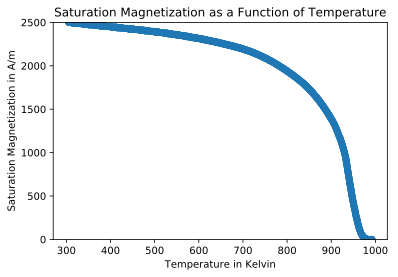

In [6]:
plt.scatter(MsT_data.temp_kelvin,MsT_data.MsT_Am)
plt.ylim(0,2500)
plt.ylabel('Saturation Magnetization in A/m')
plt.xlabel('Temperature in Kelvin')
plt.title('Saturation Magnetization as a Function of Temperature')
plt.show()

We can use these values to develop a function that interpolates for any value of temperature.

In [7]:
MsofT = interpolate.interp1d(MsT_data.temp_kelvin, MsT_data.MsT_Am)
MsofT(990)

array(0.)

## Converting T to A/m

Define a converter to convert one Tesla to Amps per meter where 1 Tesla = 7.95775 10^5 Amps/meter.

In [8]:
converter = 7.95775E5

## Hc(T) curve

Following Pullaiah (1975) we take Hc(T) to be proportional to Ms(T)^3. From Dunlop 1991 the Hco for synthetic hematite between 200 and 700 nm is 405 mT. Another possible value to use would be 260 mT that would be for hematite of 500 to 3000 nm from a natural sample.

This approach could be imporved by using the Hc(T) data of Ozdemir and Dunlop (2014) which show a faster initial decrease and then a ^1.8 decrease. There is also a strong relationship between Hc and grain size that should be considered and which Ozdemir and Dunlop (2014) fit with a polynomial. I have emailed Ozden requesting these data in order to improve the approach for determining Hc as a function of T and grain size:

Dear Özden,

For the purpose of estimating the grain sizes of hematite unblocking at varying temperatures in natural samples, I am interested in having a tabulated version of the data that make up the Ms(T) and Hc(T) curves in Figure 7b as well as that in the Hc vs. grain size plot of Figure 10 of your paper "Hysteresis and coercivity of hematite." Would you be able to send these data along?

Kind regards, and thanks,

Nick

In [9]:
def HcT_mT(temp_array):
    Hc_list = []
    Hc = 260
    for n in range(0,len(temp_array)):
        Hc_for_temp = Hc * MsofT(temp_array[n])**3/MsofT(305)**3
        Hc_list.append(Hc_for_temp)
    return(np.array(Hc_list))

def HcT_Am(temp_array):
    Hc_list = []
    Hc = 260 * 10**-3 * converter
    for n in range(0,len(temp_array)):
        Hc_for_temp = Hc * MsofT(temp_array[n])**3/MsofT(305)**3
        Hc_list.append(Hc_for_temp)
    return(np.array(Hc_list))

def HcT_Am_one(temp):
    Hc_list = []
    Hc = 260 * 10**-3 * converter
    Hc_for_temp = Hc * MsofT(temp)**3/MsofT(305)**3
    return(Hc_for_temp)

In [10]:
temps = np.arange(305,990,1)
HcT_values_mT = HcT_mT(temps)
HcT_values_Am = HcT_Am(temps)

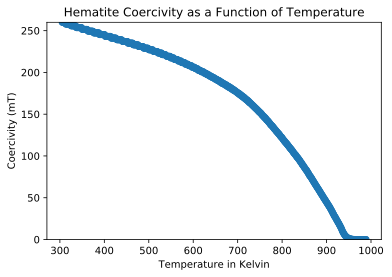

In [11]:
plt.scatter(temps,HcT_values_mT)
plt.ylim(0,260)
plt.ylabel('Coercivity (mT)')
plt.xlabel('Temperature in Kelvin')
plt.title('Hematite Coercivity as a Function of Temperature')
plt.show()

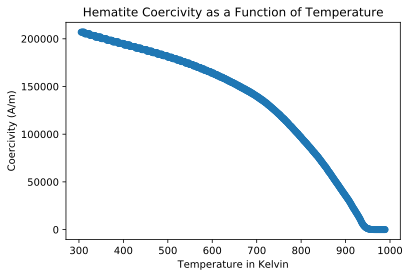

In [12]:
plt.scatter(temps,HcT_values_Am)
plt.ylabel('Coercivity (A/m)')
plt.xlabel('Temperature in Kelvin')
plt.title('Hematite Coercivity as a Function of Temperature')
plt.show()

## Using the Hc(T) and Ms(T) curves to determine unblocking temperature with changing grain radius and relaxation time

This section of the code works by taking the above defined Hc(T) and Ms(T) curves and using them in the Neel relaxation time equation. We are interested in determining the temperatures at which grains of varying size have their relaxation times go to laboratory timescales (i.e. 10 minutes).

The choice of thermal fluctuation rate matters little for the result so we will use a value of 10^10 Hz. 

We approximate grains to be spheres in order to simply define a volume on the basis of radius.

$\tau=C^{-1}e^{\frac{v\mu_{o}M_{s}H_{c}}{2kT}}$

In [36]:
def relax_time(grain_diameter, temp):
    """
    grain_diameter : grain diameter in nanometers
    temp : temperature in Kelvin
    """
    volume = (4/3) * np.pi * ((grain_diameter * 1E-9)/2)**3
    tau = (1e10)**-1 * np.exp((volume * mu * HcT_Am_one(temp) * MsofT(temp))/(2*boltzman*temp))
    return tau

In [28]:
grain_diameter_list = np.arange(0,500)
tau_at_923 = relax_time(grain_diameter_list, 923)

grain_diameter_list = np.arange(0,500)
tau_at_373 = relax_time(grain_diameter_list, 373)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


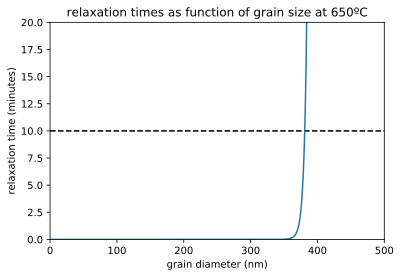

In [34]:
plt.plot(grain_diameter_list,tau_at_928/60)
plt.ylim(0,20)
plt.xlim(0,500)
plt.hlines(10,0,500,linestyles='dashed')
plt.ylabel('relaxation time (minutes)')
plt.xlabel('grain diameter (nm)')
plt.title('relaxation times as function of grain size at 650ºC')
plt.show()

In [37]:
relax_time(375,650+273)/60

2.562926650160482

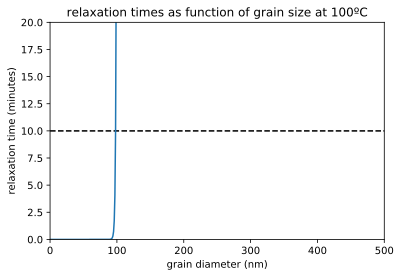

In [35]:
plt.plot(grain_diameter_list,tau_at_373/60)
plt.ylim(0,20)
plt.xlim(0,500)
plt.hlines(10,0,500,linestyles='dashed')
plt.ylabel('relaxation time (minutes)')
plt.xlabel('grain diameter (nm)')
plt.title('relaxation times as function of grain size at 100ºC')
plt.show()

From Özdemir and Dunlop (2014):

> SD hematite is increasingly affected by thermal fluctuations below ≈0.3 μm and generally confirm a superparamagnetic threshold size ds of 0.025-0.03 μm